### Overview
This project aims to build a cutting-edge, machine learning-powered framework for asset return forecasting, risk prediction, and portfolio optimization. Combining rigorous quantitative finance techniques with modern data science workflows, the system will leverage market data and advanced ML models to enhance risk-adjusted returns and demonstrate state-of-the-art portfolio management analytics.
___

### Objectives
1) Predict asset returns or volatility using machine learning techniques
2) Engineer informative financial features from historical price, volume, and macroeconomic data
3) Construct and evaluate robust, data-driven portfolio allocation strategies
4) Quantify and visualize portfolio risks using industry-standard metrics (e.g., VaR, Sharpe ratio, drawdown)
5) Provide fully reproducible, commented code and a comprehensive walkthrough of all methodologies.
___

###  Workflow
1) Data Collection: Source and preprocess historical market and macroeconomic data for selected assets.
2) Exploratory Data Analysis: Investigate statistical properties, visualize trends, and identify key drivers.
3) Feature Engineering: Extract and construct relevant features (technical indicators, rolling stats, etc.)

##### Machine Learning Modeling:

1) Select regression or classification models (Linear Regression, Random Forest, XGBoost/LSTM, etc.)
2) Tune and train models for forecasting returns/volatility.

##### Backtesting and Evaluation:
1) Simulate predictions and portfolio allocation over out-of-sample test sets.
2) Assess performance using financial metrics and realistic constraints.

##### Portfolio Optimization:
1) Implement optimization routines to construct portfolios that maximize risk-adjusted returns.
2) Integrate ML predictions into allocation strategies.

##### Visualization and Reporting:
1) Generate plots (prediction vs. actual, cumulative returns, feature importance)
2) Summarize key results and business implications

##### Documentation:
Ensure all code sections and methodology are clearly explained for full reproducibility and understanding.


In [1]:
# Import Nessecary Libraries

# Data handling and manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and modeling
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline 

# Advanced models (if needed later)
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# For feature scaling
from sklearn.preprocessing import StandardScaler

# For saving/loading models and saving folders
import pickle
import joblib as jb
import os 

# For downloading data
import pandas_datareader as pdr


os.makedirs('Results', exist_ok=True)

In [2]:
# Step 1 gathering the relevant data and processing it for the model training and developement 

from datetime import datetime

# Define tickers and date range
tickers = ['MSFT','AAPL','SPY','AMZN','TSLA','NVDA']
data_frames = []
start_date = datetime(2010, 1, 1)  
end_date = datetime.today()

for ticker in tickers:
    df = pdr.get_data_stooq(ticker, start=start_date, end=end_date)  # OHLCV data
    df.columns = pd.MultiIndex.from_product([[ticker], df.columns])    # multi-level columns with ticker
    data_frames.append(df)

# Concatenate all ticker DataFrames on columns to form a multi-level DataFrame
Data = pd.concat(data_frames, axis=1).sort_index(axis=1)


In [3]:

# checking mssing values per ticker columns and interpoladin them to get the data continoius 
null_cols =[]
for ticker in Data.columns:
    if Data[ticker].isna().sum() > 0:
        null_cols.append(ticker)
    else:
        pass
    
null_cols

# fitting and filling the missing values using interpolation
Data.loc[:, null_cols] = Data.loc[:, null_cols].interpolate(method='time',degree=1).ffill().bfill()



In [4]:
# NOw perfoming the EDA and Feature Engineering to observe the trends and the important feaures

# Feature Engineering 
Feature_list = ['Pct_returns','Log_Returns','Rolling_Mean_returns','Rolling_STD','Rolling_Skewness','Rolling_Kurtosis',
                'SMA(20)','SMA(50)','EMA','MACD','RSI','BOLLINGER_BANDS',
                'Day_of_Week','Month','Year','Week_of_Year','Day_of_Year','Weekend','Holiday',
                'Rolling_Correlations'
                ]


import numpy as np
import pandas as pd

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

def compute_bollinger_bands(series, window=20):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = sma + 2 * std
    lower_band = sma - 2 * std
    return upper_band, lower_band

technical_features = {}

for ticker in Data.columns.get_level_values(0).unique():
    close = Data[ticker]['Close']
    high = Data[ticker]['High']
    low = Data[ticker]['Low']
    volume = Data[ticker]['Volume']
    Data[(ticker,'log_returns')] = np.log(Data[ticker]['Close'] / Data[ticker]['Close'].shift(1))
    Data[(ticker,'Pct_change')] = (Data[ticker]['Close'] - Data[ticker]['Close'].shift(1)) / Data[ticker]['Close'].shift(1)
    Data[(ticker,'rolling_logvol_30')] = Data[(ticker,'log_returns')].rolling(window=30).std()
    
    # RSI (14-day)
    technical_features[(ticker, 'RSI_14')] = compute_rsi(close)
    
    # MACD
    macd, signal_line, hist = compute_macd(close)
    technical_features[(ticker, 'MACD')] = macd
    technical_features[(ticker, 'MACD_Signal')] = signal_line
    technical_features[(ticker, 'MACD_Histogram')] = hist
    
    # Bollinger Bands
    upper_band, lower_band = compute_bollinger_bands(close)
    technical_features[(ticker, 'Bollinger_Upper')] = upper_band
    technical_features[(ticker, 'Bollinger_Lower')] = lower_band
    
    # SMA and EMA
    technical_features[(ticker, 'SMA_20')] = close.rolling(window=20).mean()
    technical_features[(ticker, 'EMA_20')] = close.ewm(span=20, adjust=False).mean()
    
    # Average True Range (ATR) - volatility measure
    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = true_range.rolling(window=14).mean()
    technical_features[(ticker, 'ATR_14')] = atr
    
    # On Balance Volume (OBV) - volume momentum
    direction = np.sign(close.diff())
    obv = (direction * volume).fillna(0).cumsum()
    technical_features[(ticker, 'OBV')] = obv

# Combine all features into a DataFrame
tech_indicators_df = pd.DataFrame(technical_features)

# Sort columns by ticker and feature
tech_indicators_df = tech_indicators_df.sort_index(axis=1, level=[0, 1])

Data.sort_index(axis=1, level=[0, 1], inplace=True)

Final_Data = pd.concat([Data, tech_indicators_df], axis=1).sort_index(axis=1, level=[0, 1])

Final_Data.to_csv('Results/Final_Data.csv')

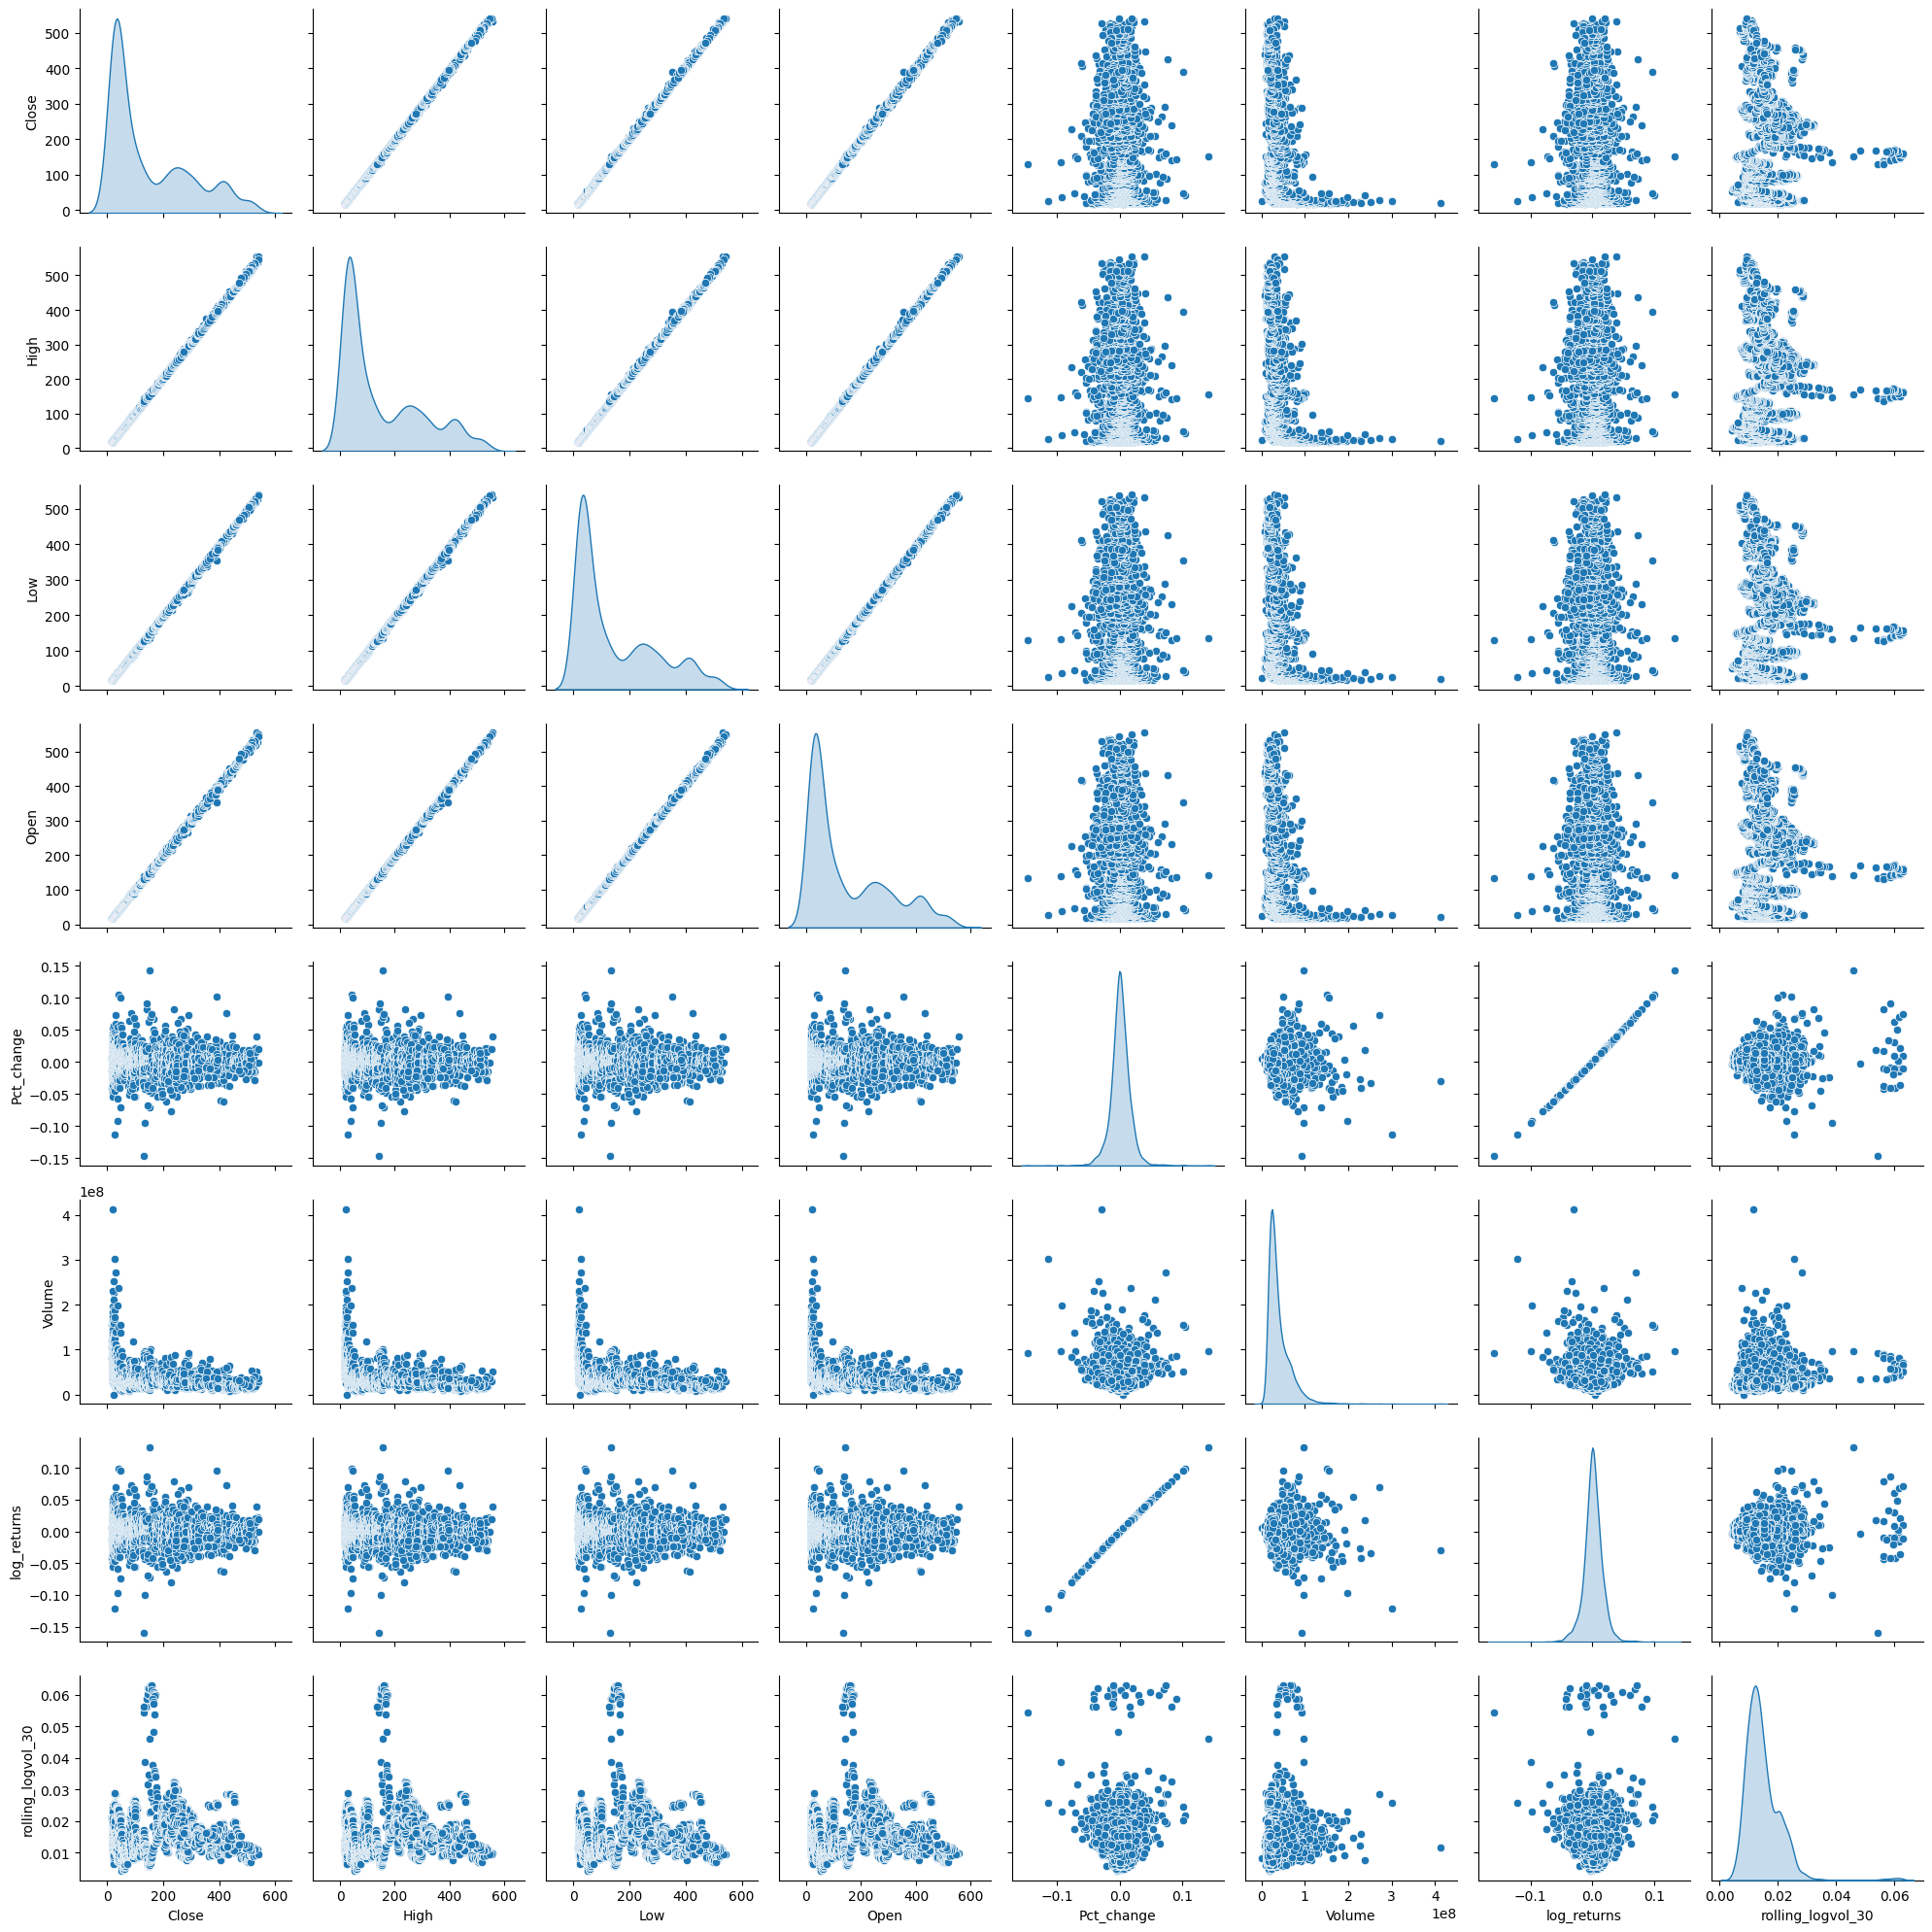

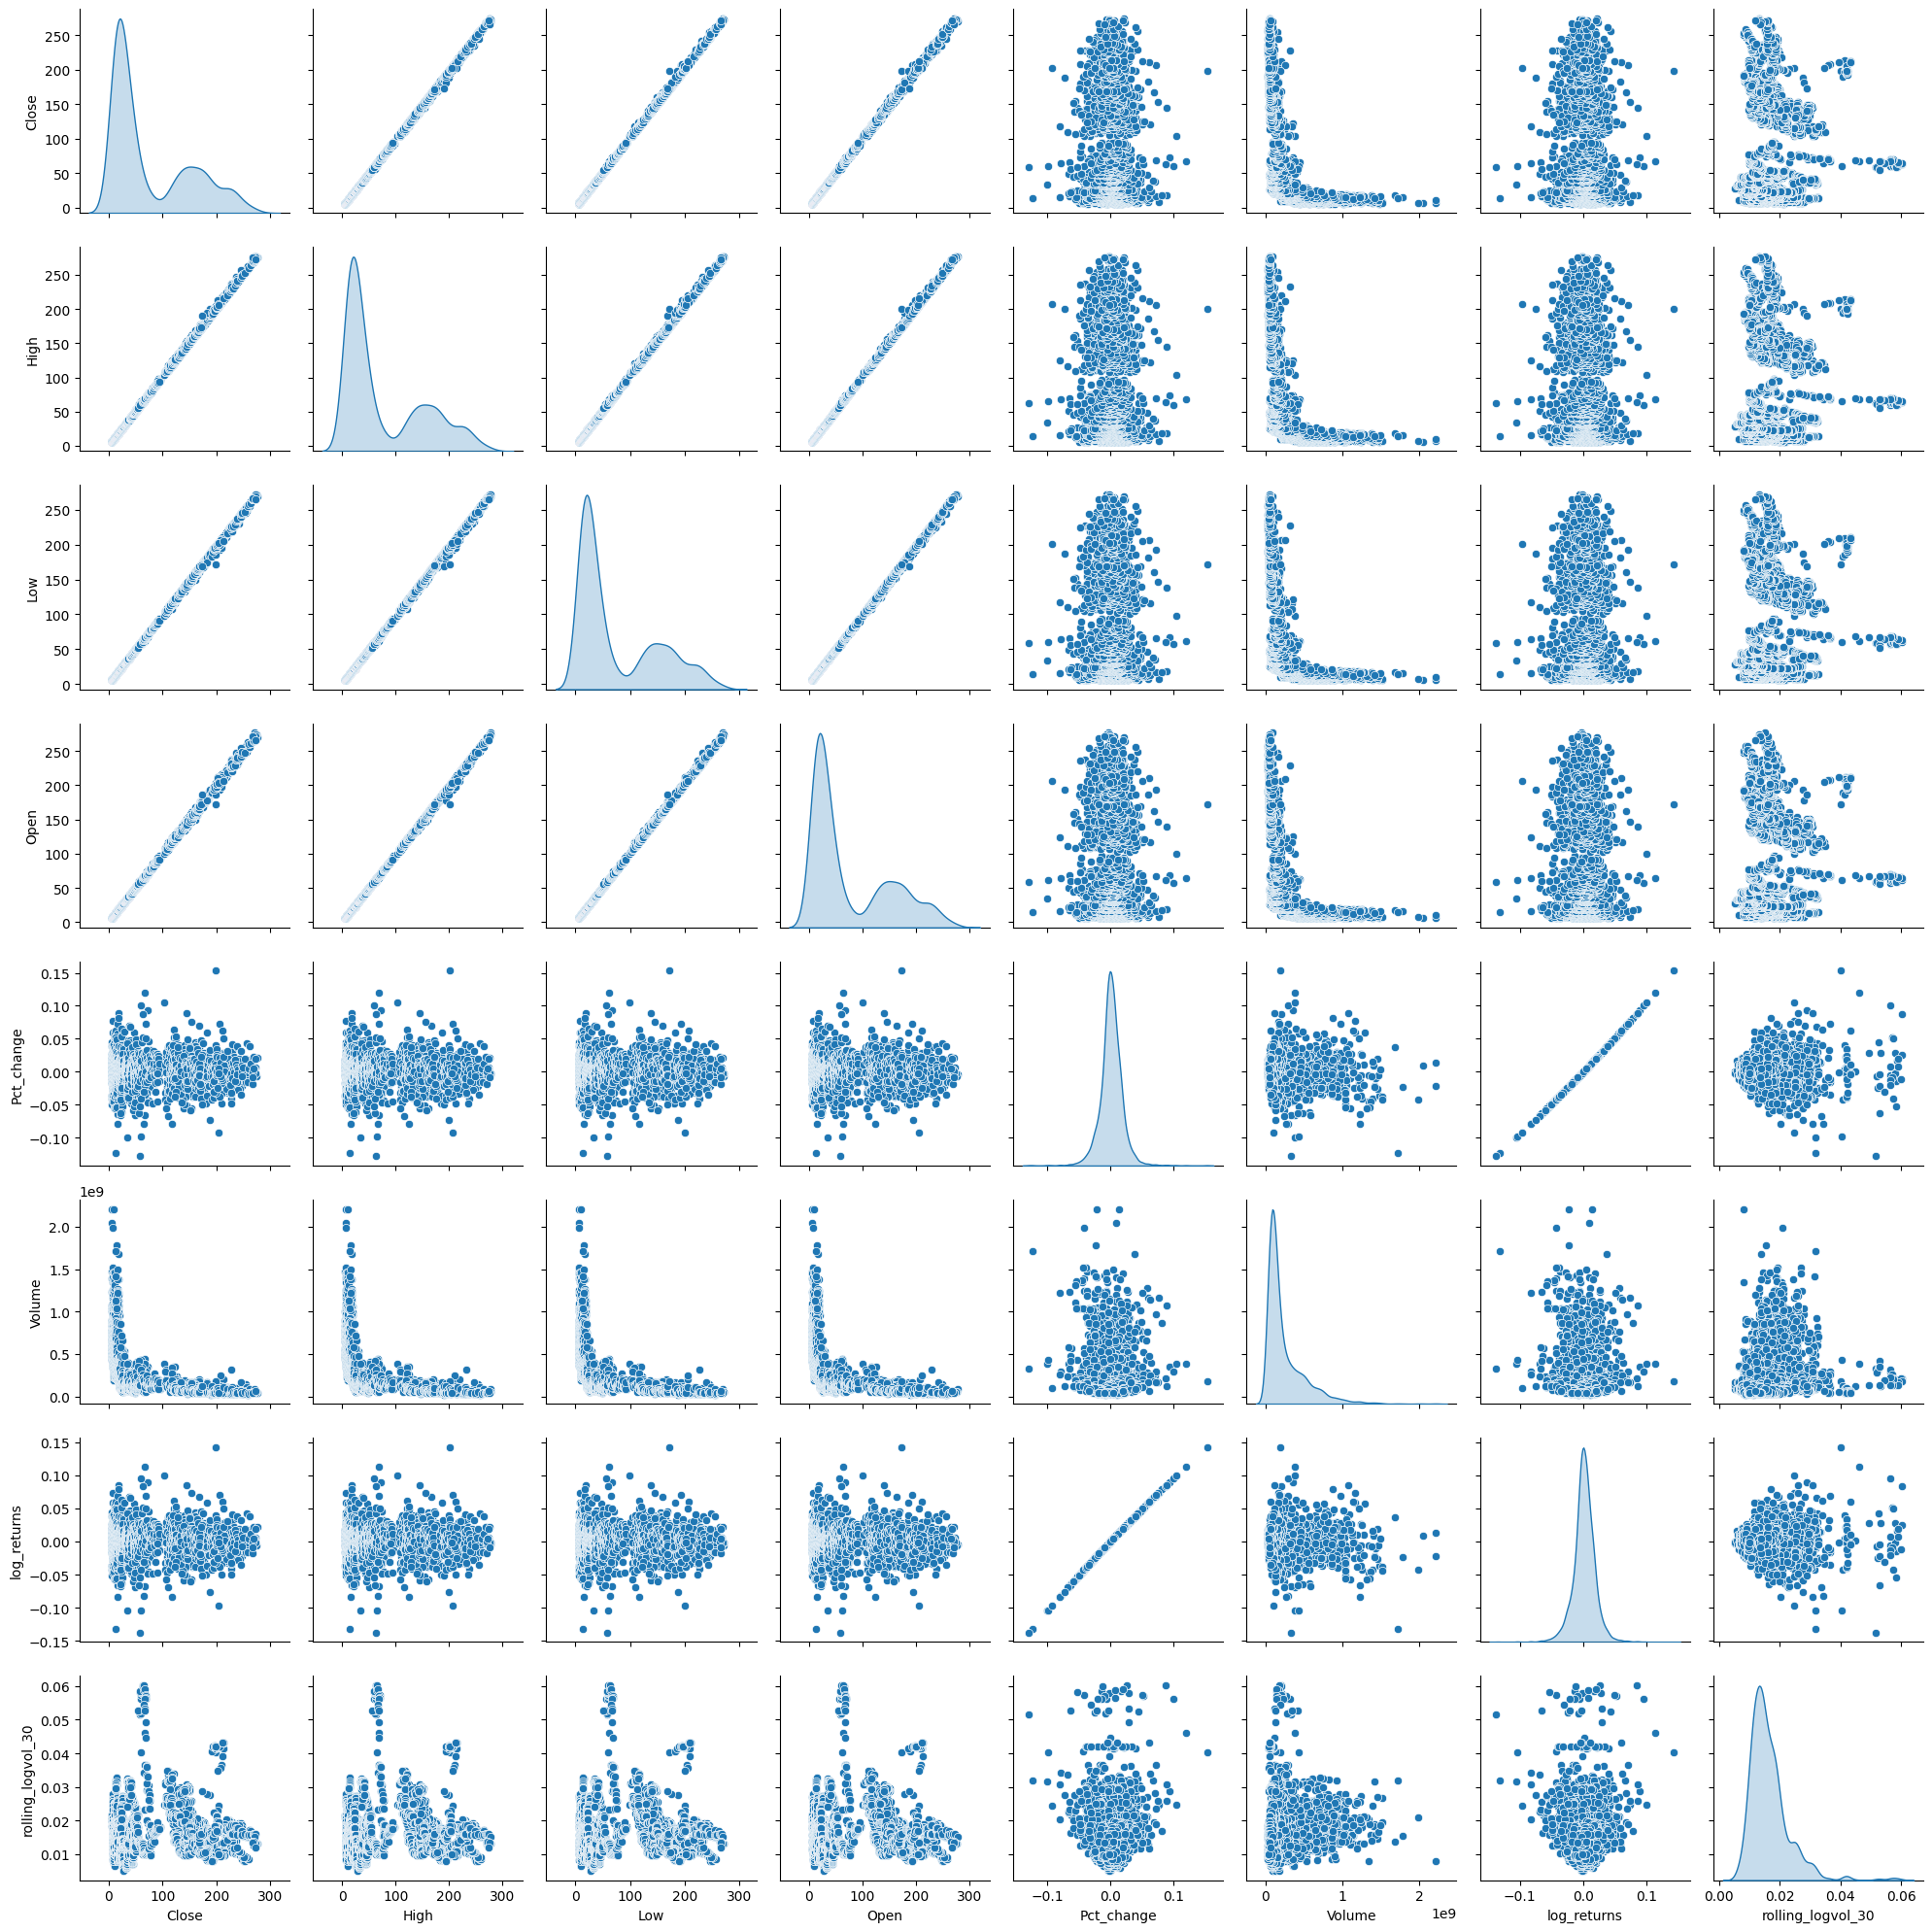

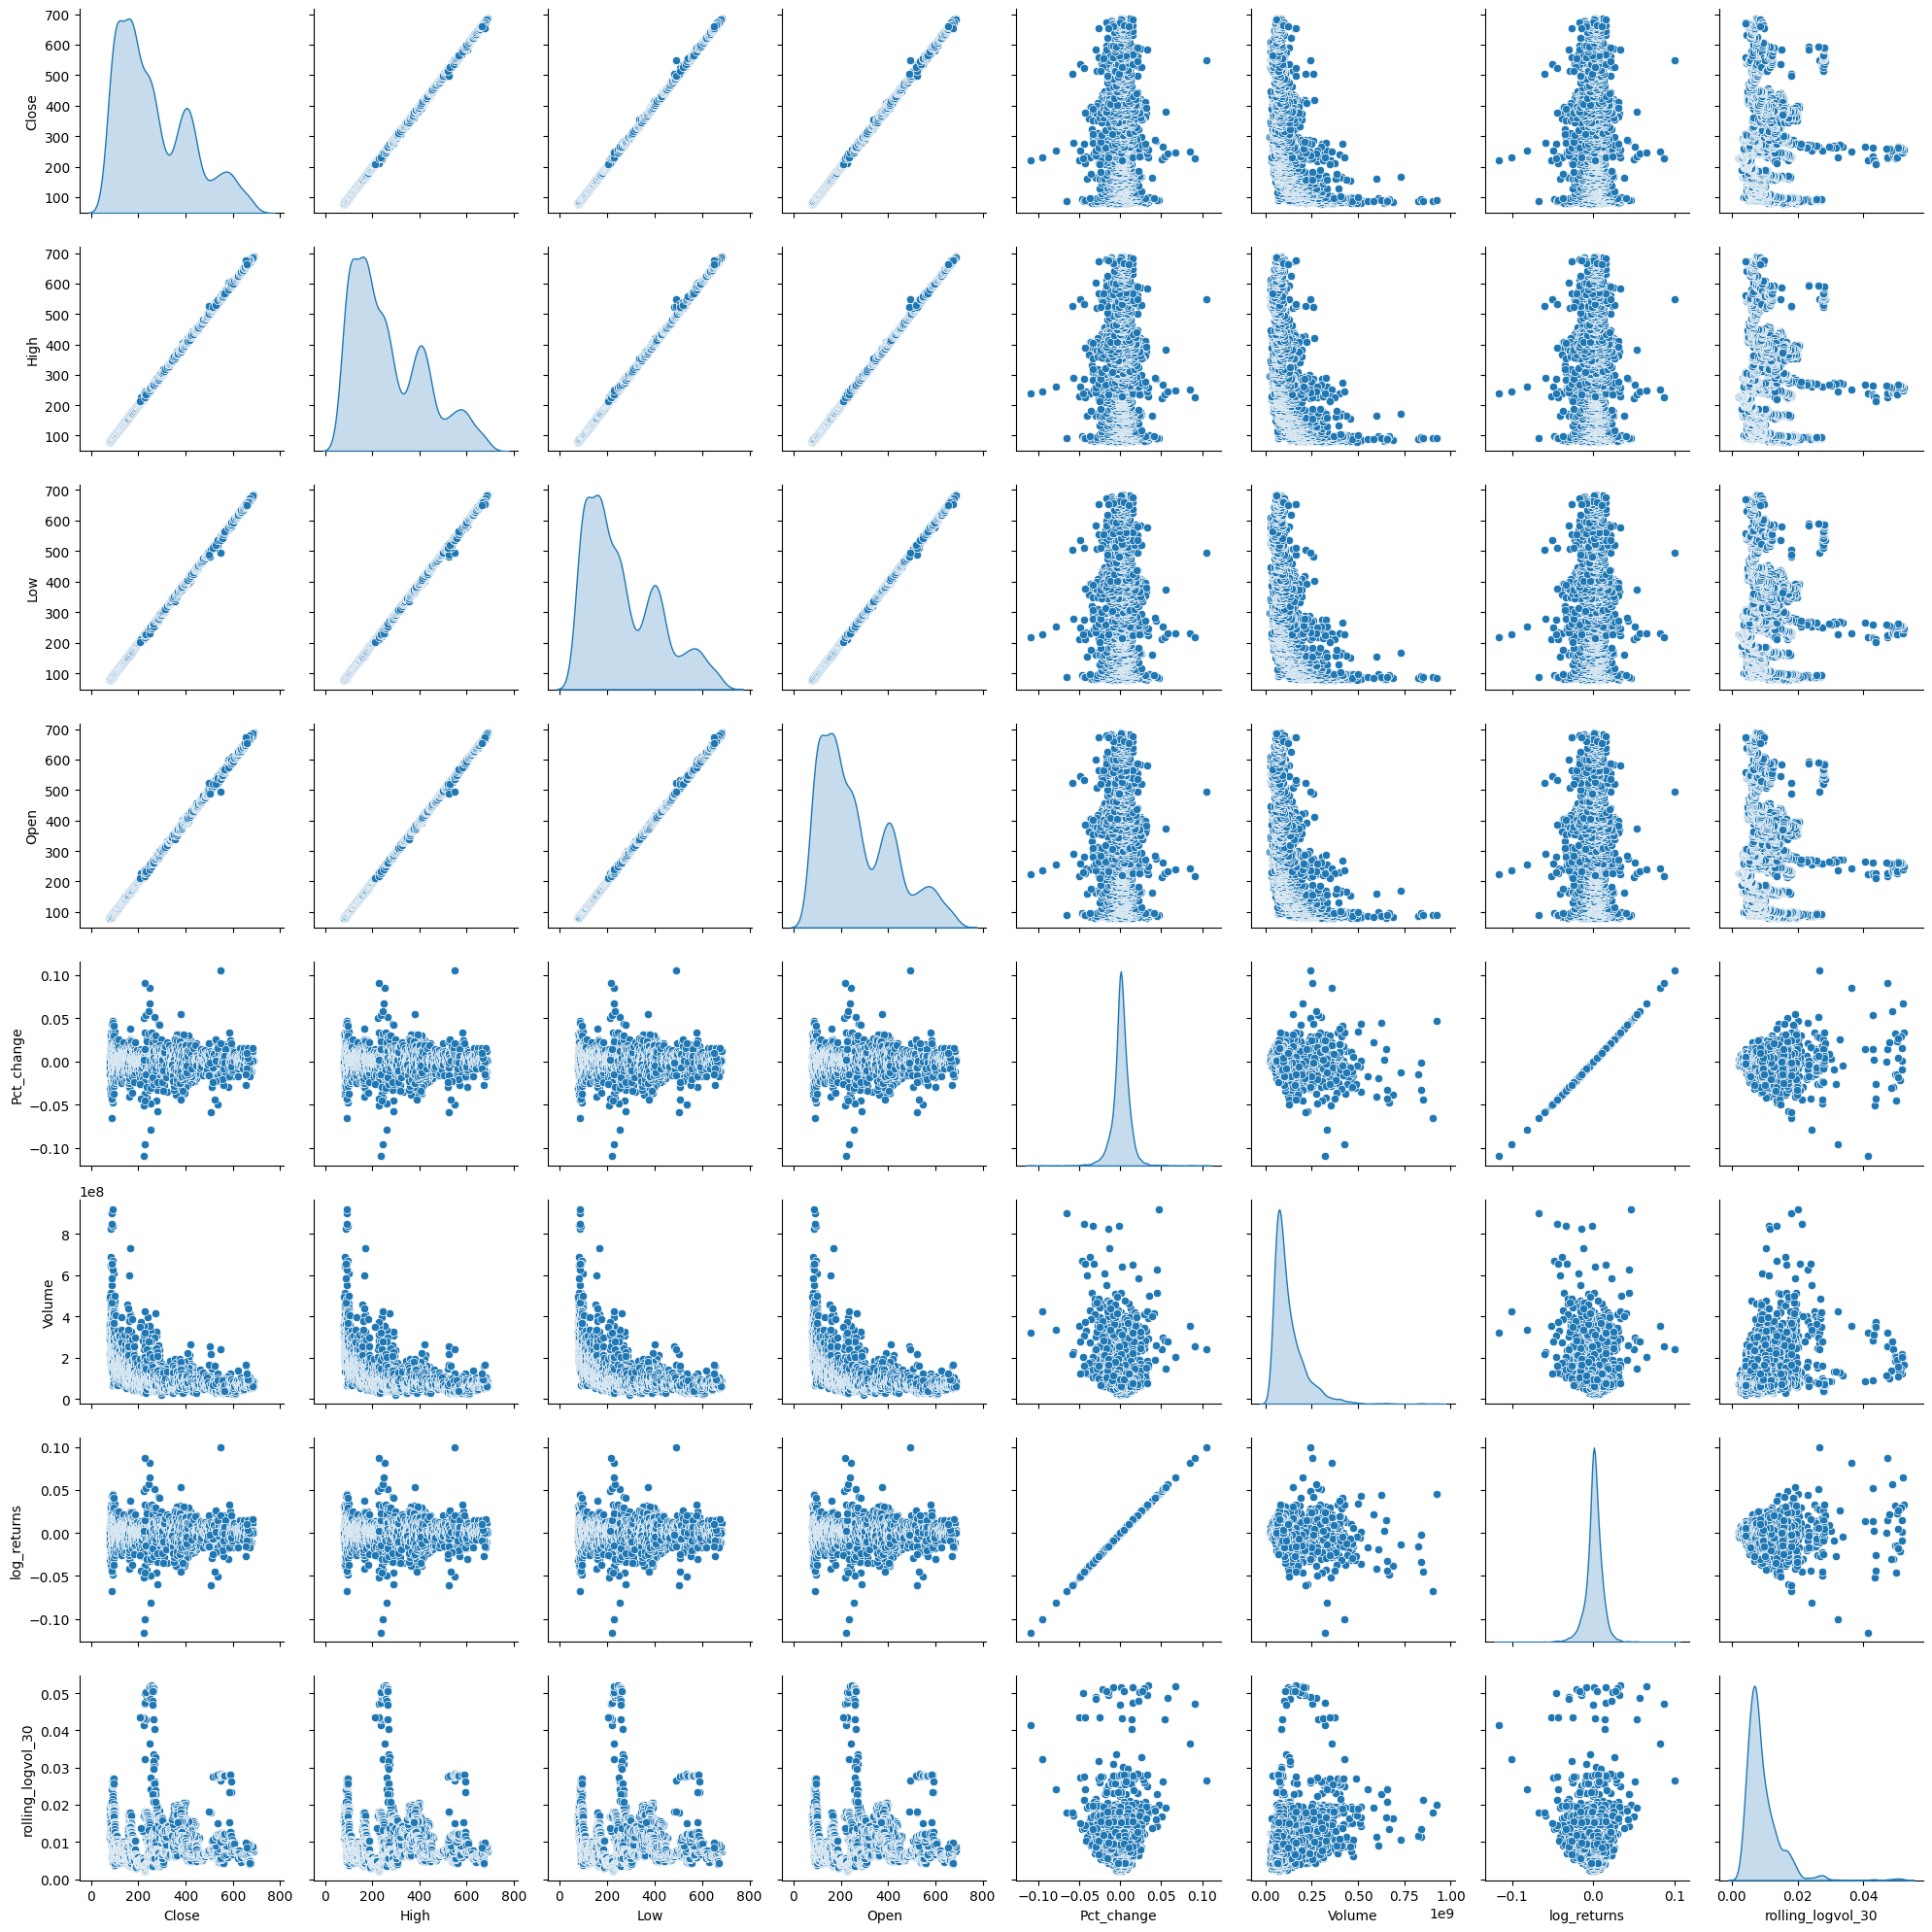

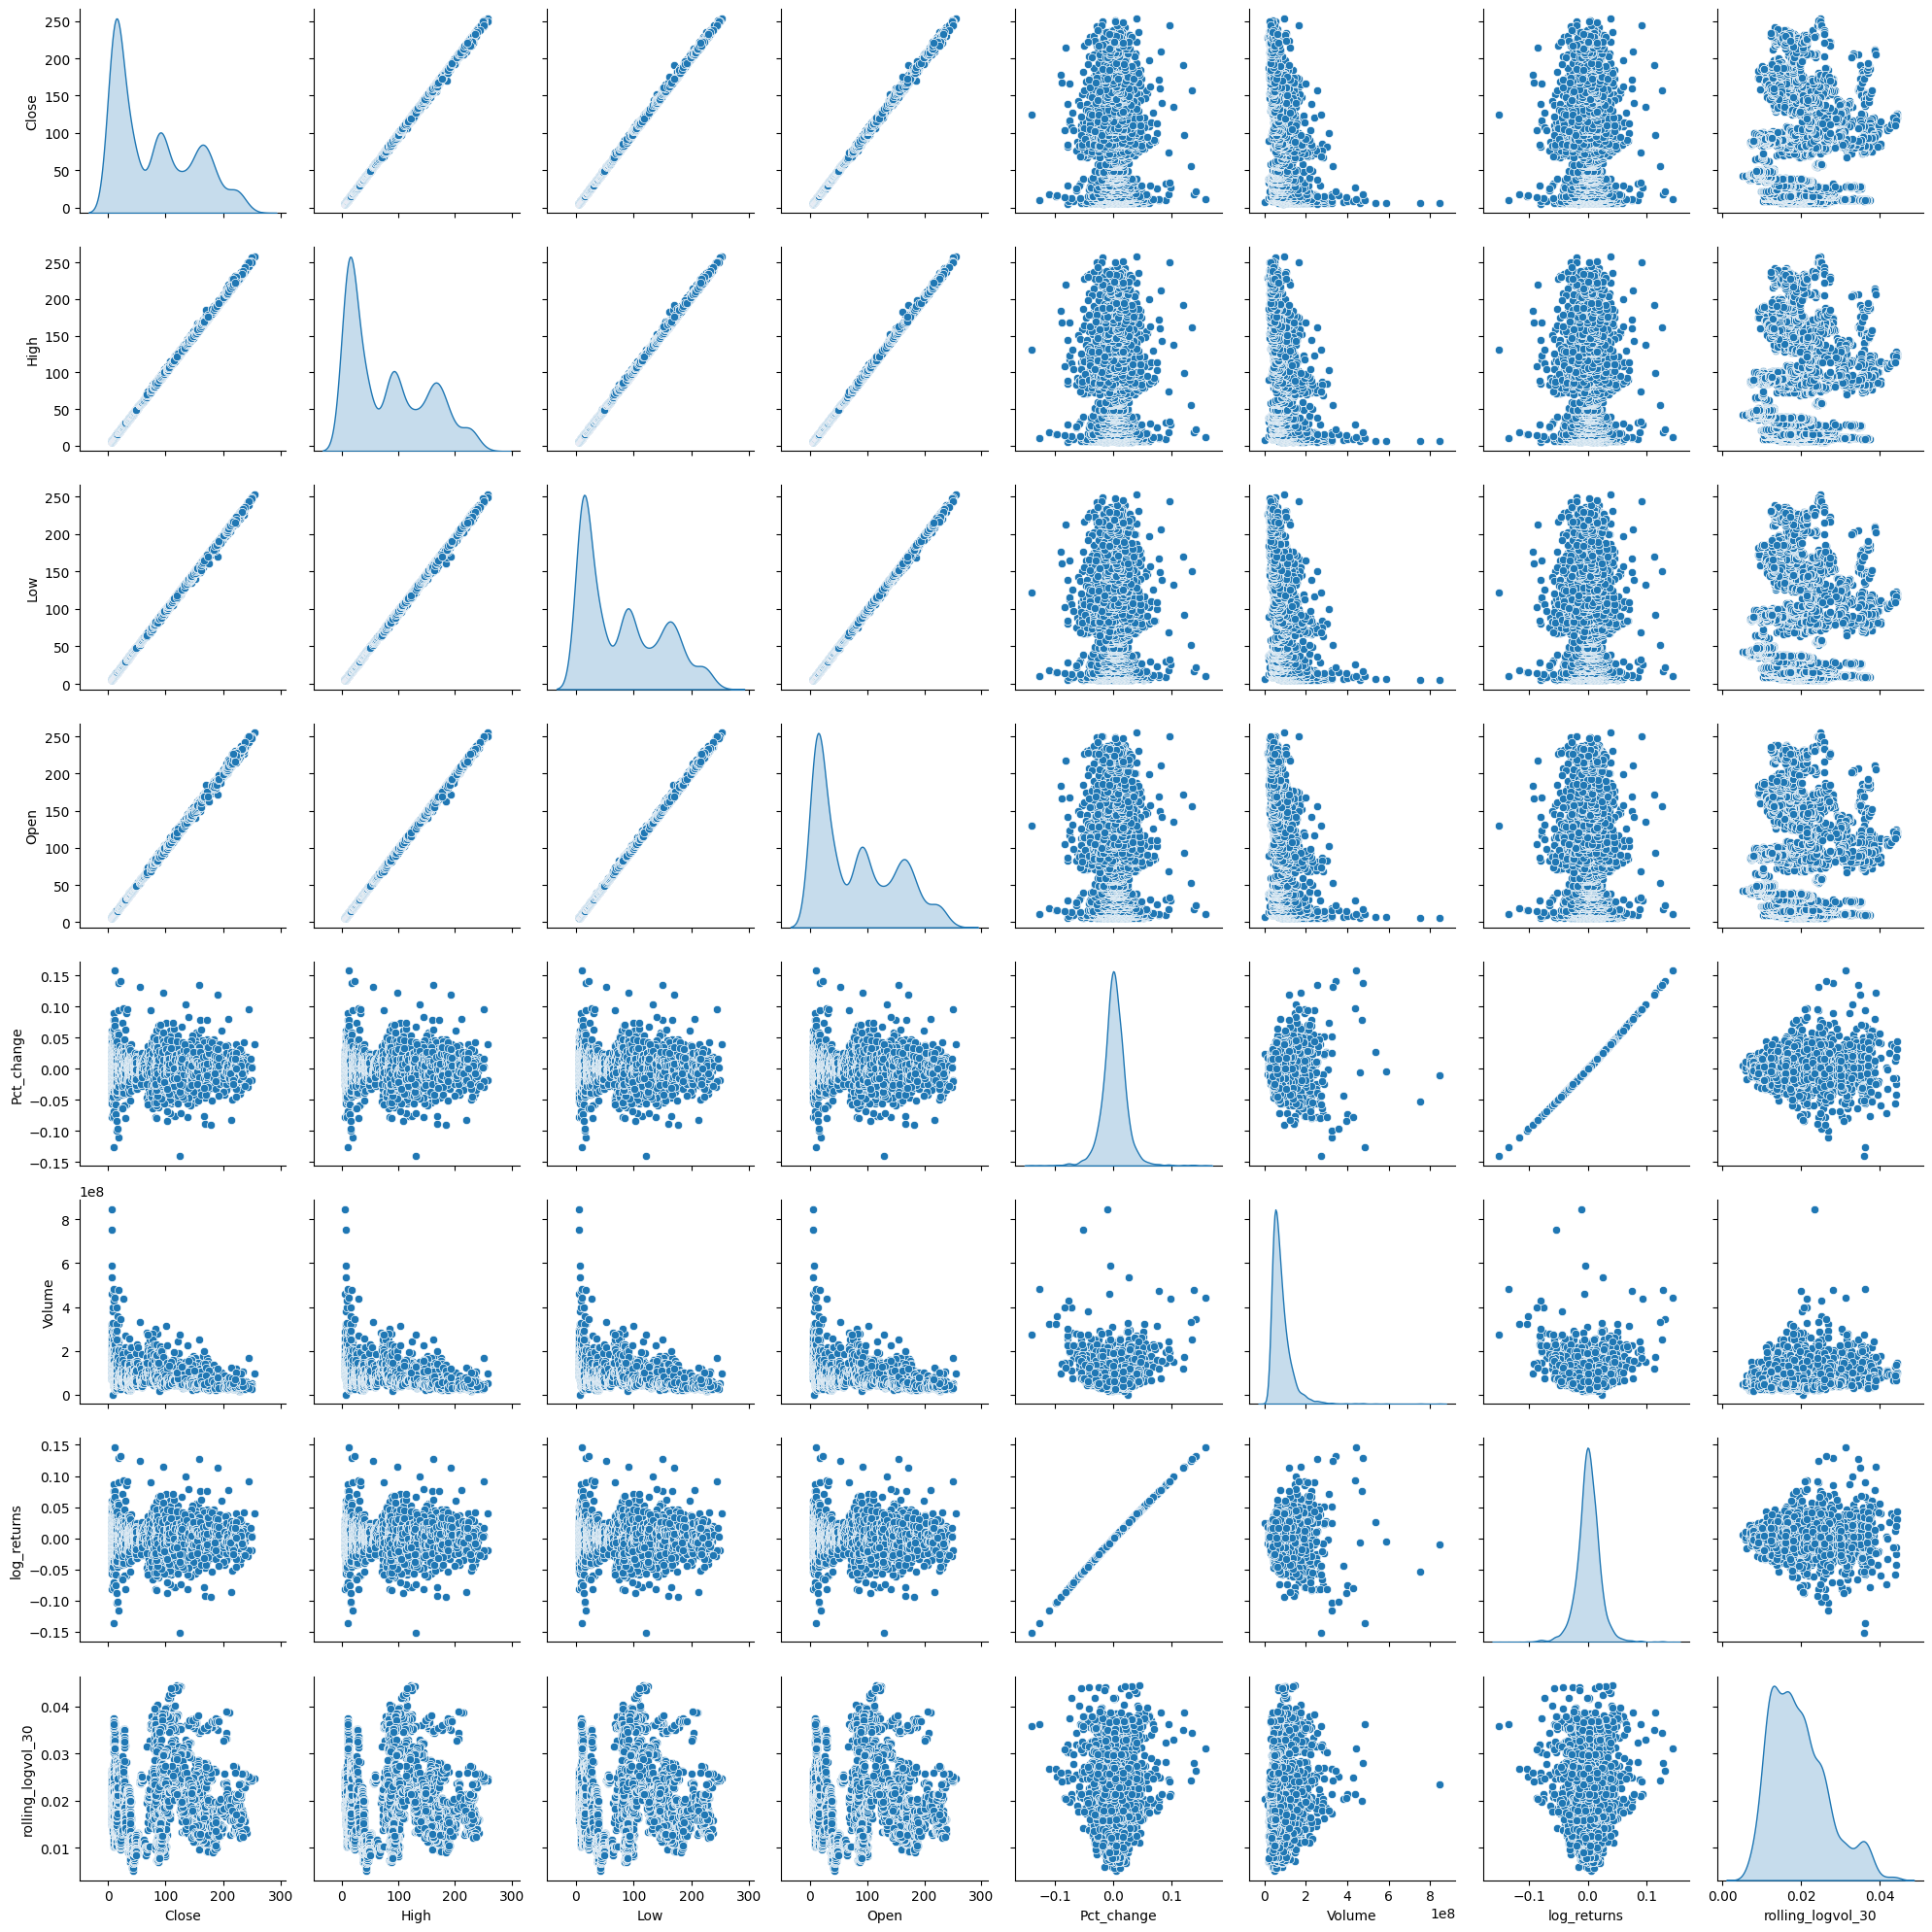

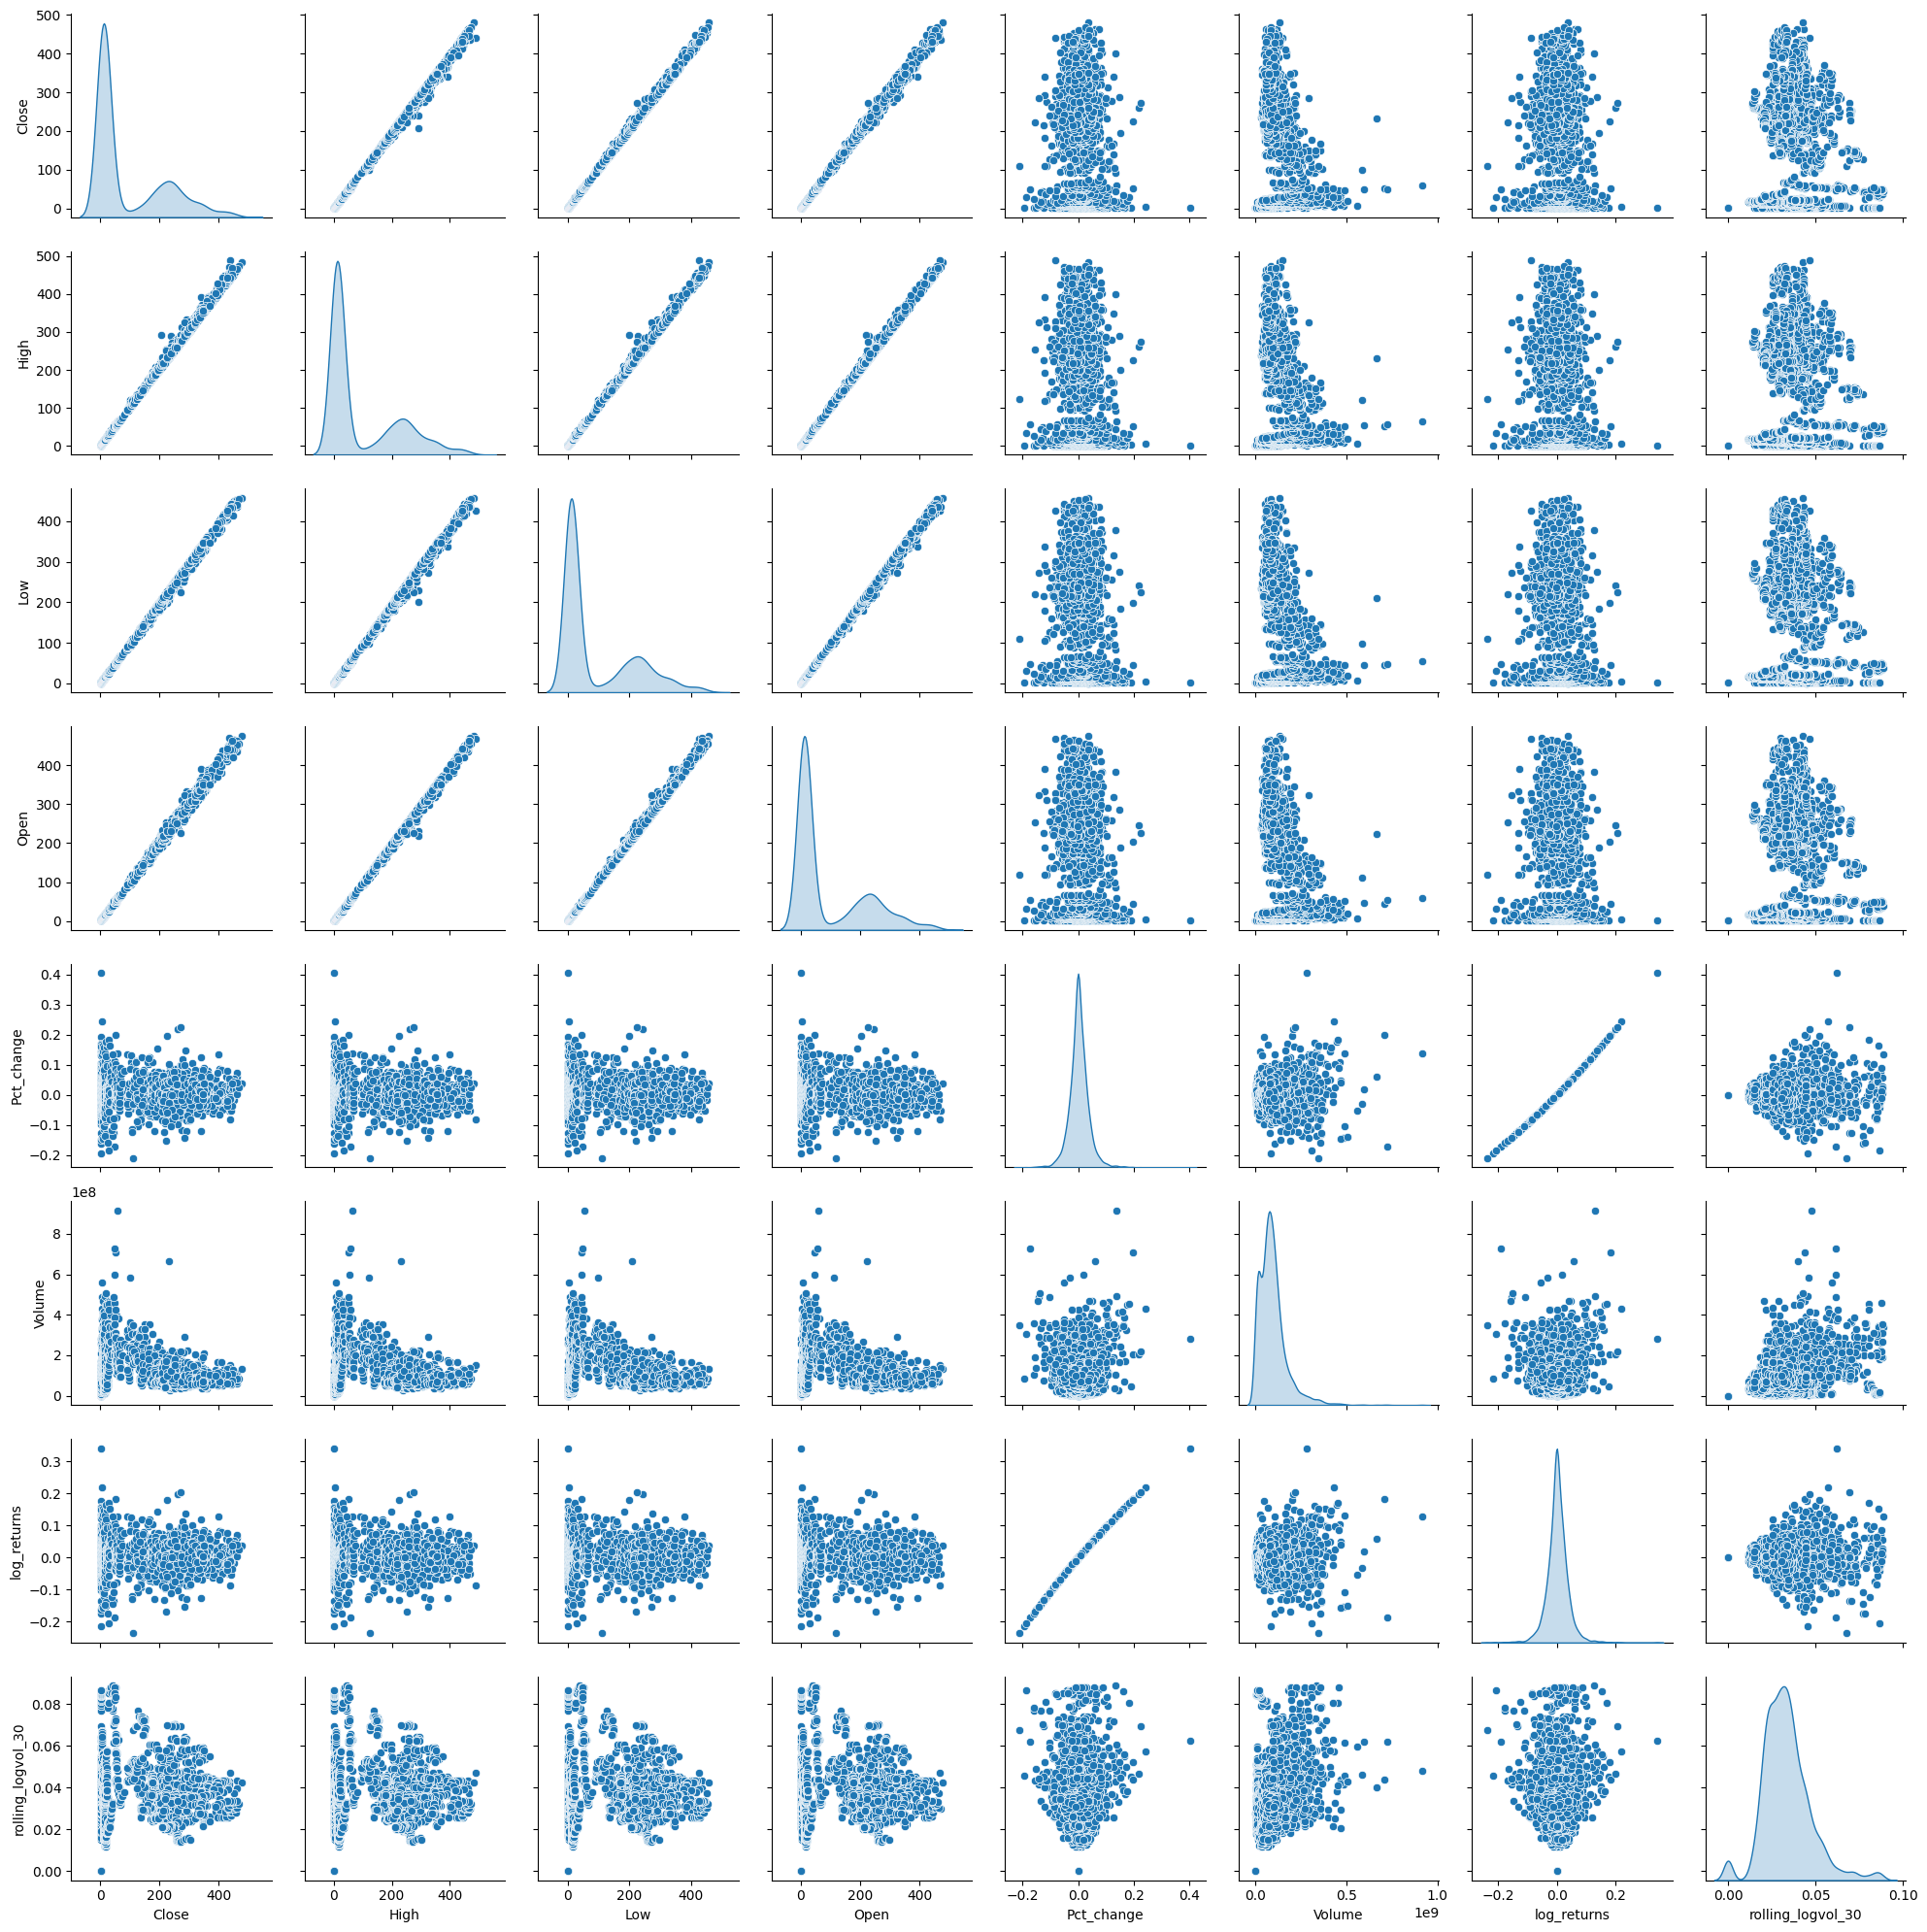

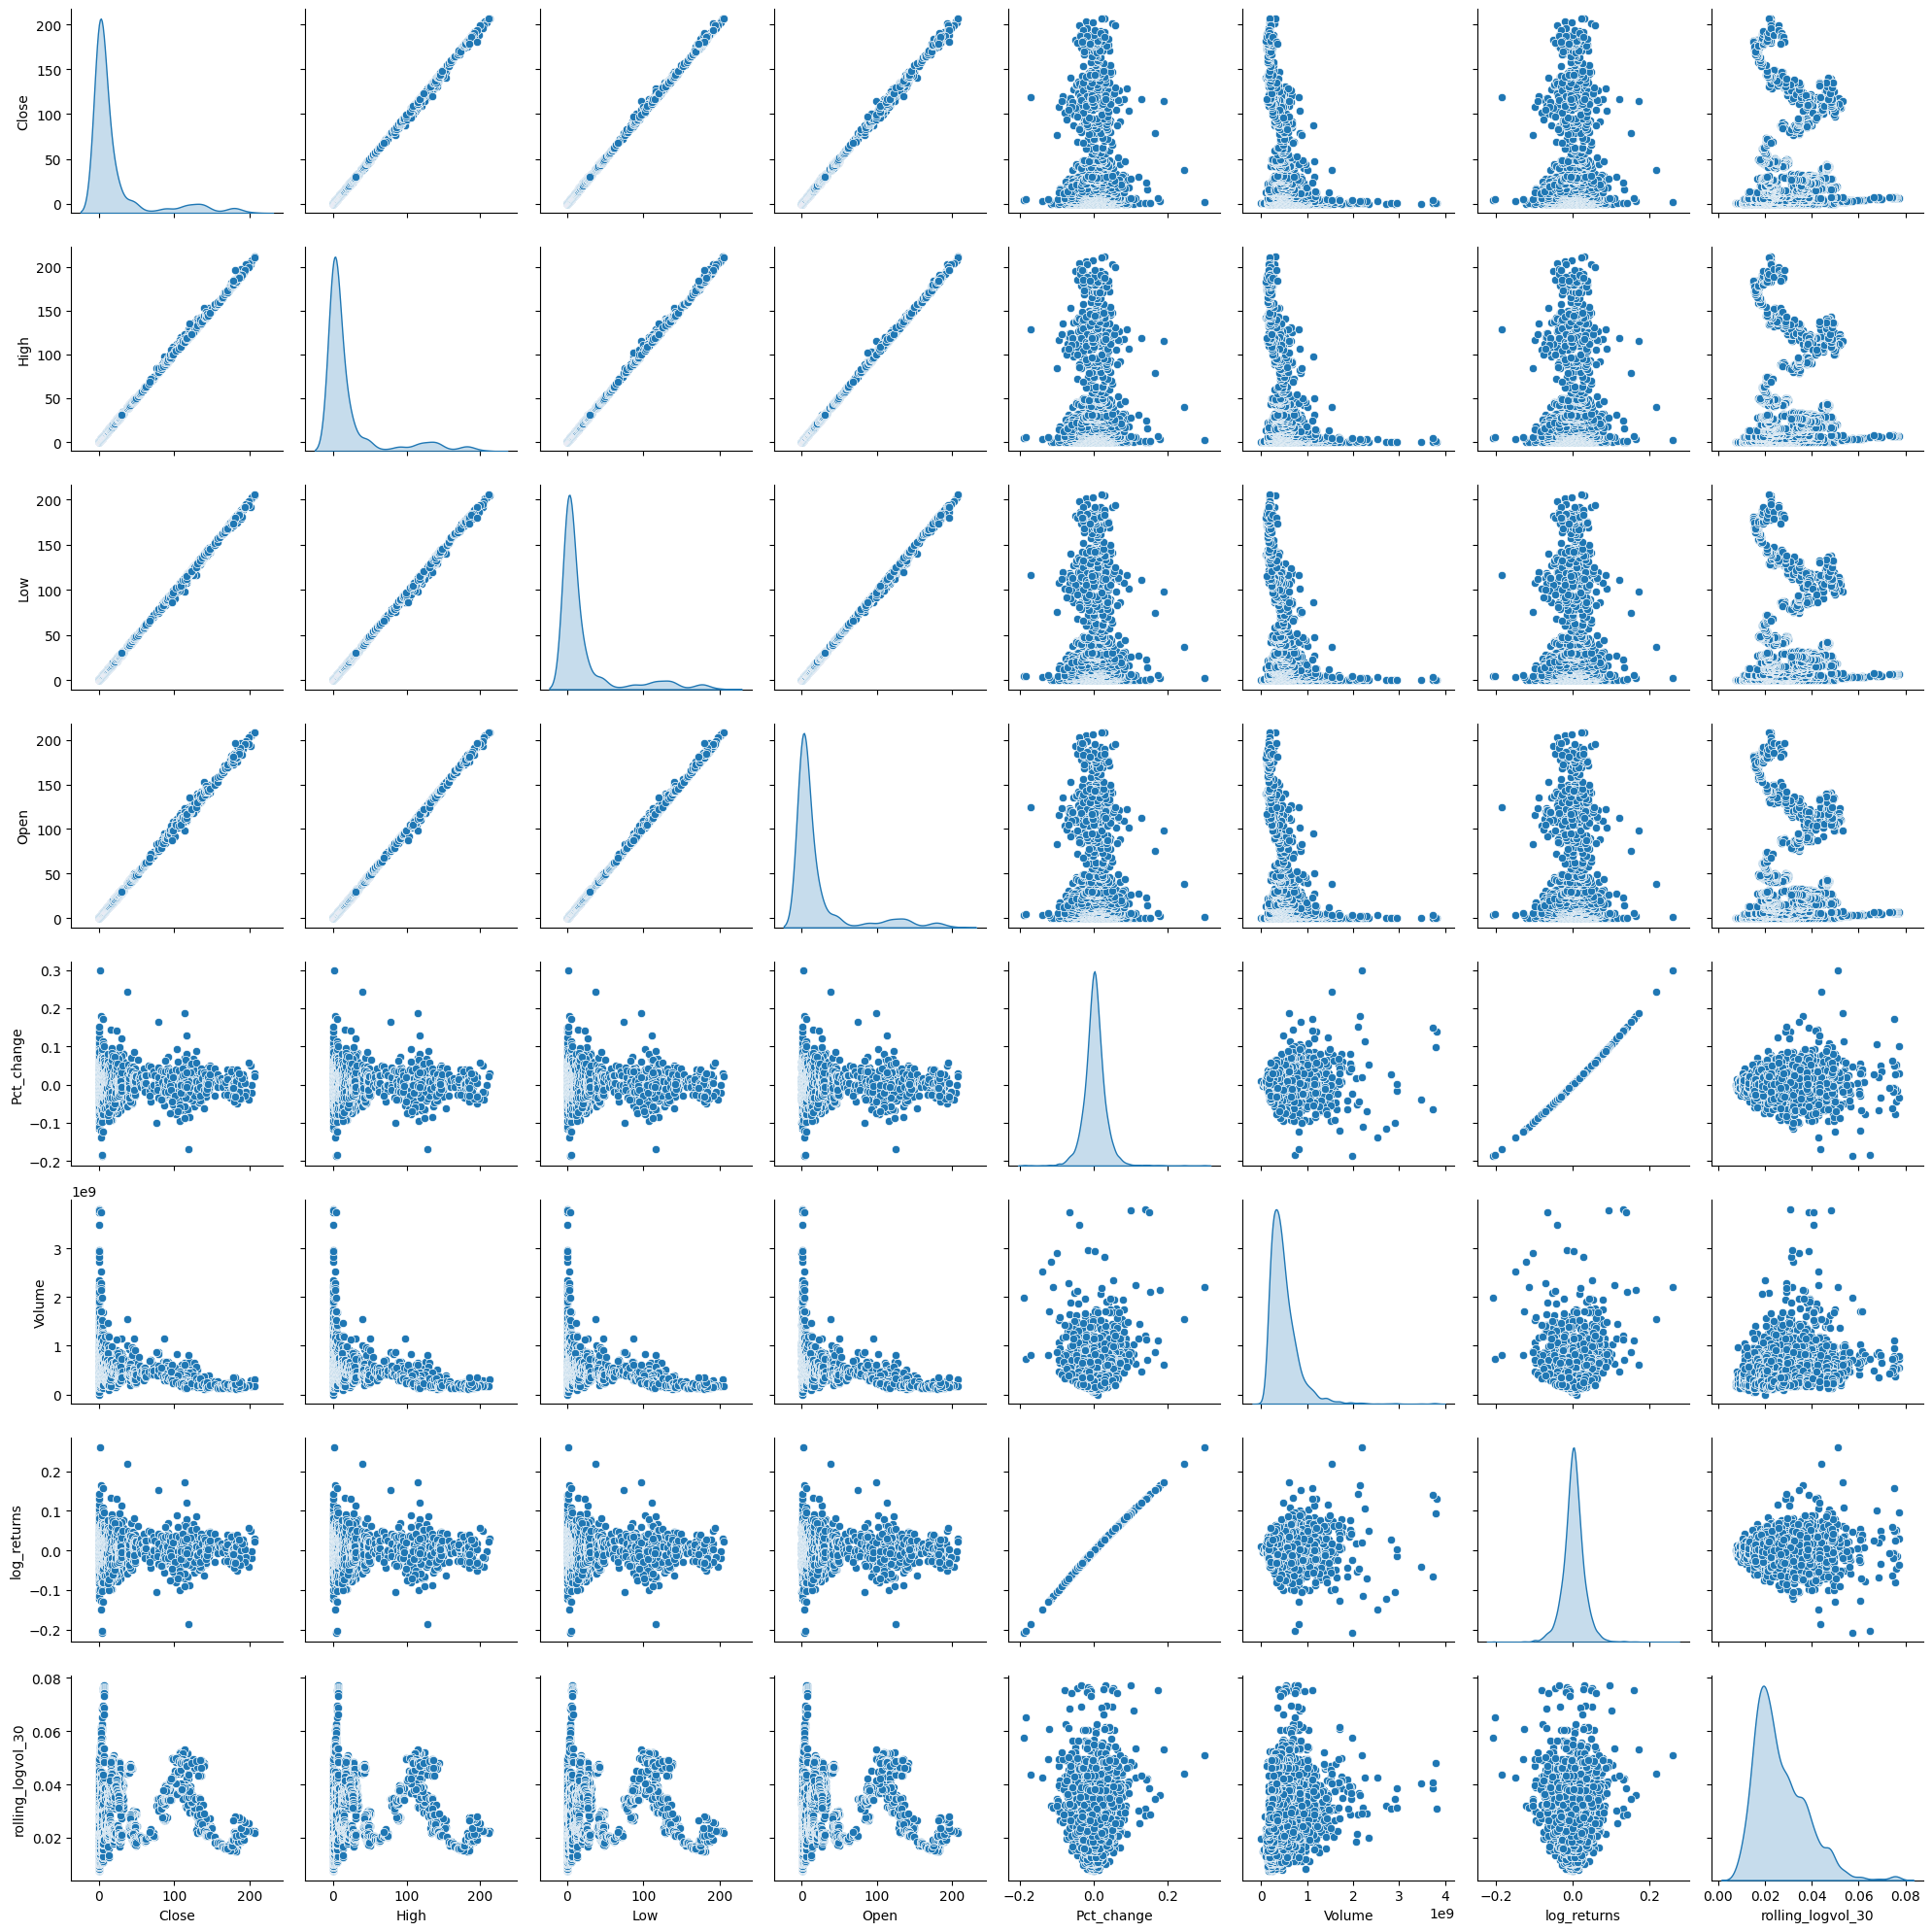

In [5]:
# Now we do EDA and then feature slection for our model that is what arr the iportant fetaure for our model

# lets have pair plots for the Data frame to get the important relaton between features


for ticker in tickers:
    sns.pairplot(Data[ticker], diag_kind='kde')
    plt.tight_layout()
    plt.savefig(f'Results/{ticker}_pairplot.png')


In [6]:
# Correlation matrix for each ticker for their feataure vs log_returns
corr_matrix_dict_log_returns={}
corr_matrix_dict_rolling_logvol_30={}
for ticker in tickers:
    corr_matrix_dict_log_returns[ticker] =Final_Data[ticker].drop(columns=['log_returns','Pct_change']).dropna().corrwith(Final_Data[(ticker,'log_returns')]).sort_values(ascending=False)
    corr_matrix_dict_rolling_logvol_30[ticker] =Final_Data[ticker].drop(columns=['log_returns','rolling_logvol_30']).dropna().corrwith(Final_Data[(ticker,'rolling_logvol_30')]).sort_values(ascending=False)
    
    
# Impoetant top 10 fetaures for the log_returns and rolling vol_30 for each ticker
Features_log_returns ={}
Features_rolling_logvol_30 ={}
for ticker in tickers:
    Features_log_returns[ticker] = list(corr_matrix_dict_log_returns[ticker].head(10).index)
    Features_rolling_logvol_30[ticker] = list(corr_matrix_dict_rolling_logvol_30[ticker].head(10).index)




In [7]:
## Creating final data fro each ticker for Each tikcer and their target and rolling vol dt fames to finlay use in our train and test and model 

Model_AApl_ret = pd.concat([Final_Data['AAPL'][Features_log_returns['AAPL']],Final_Data['AAPL']['log_returns'].shift(-1)],axis=1).dropna()
Model_MSFT_ret = pd.concat([Final_Data['MSFT'][Features_log_returns['MSFT']],Final_Data['MSFT']['log_returns'].shift(-1)],axis=1).dropna()
Model_AMZN_ret = pd.concat([Final_Data['AMZN'][Features_log_returns['AMZN']],Final_Data['AMZN']['log_returns'].shift(-1)],axis=1).dropna()
Model_SPY_ret = pd.concat([Final_Data['SPY'][Features_log_returns['SPY']],Final_Data['SPY']['log_returns'].shift(-1)],axis=1).dropna()
Model_TSLA_ret = pd.concat([Final_Data['TSLA'][Features_log_returns['TSLA']],Final_Data['TSLA']['log_returns'].shift(-1)],axis=1).dropna()
Model_NVDA_ret = pd.concat([Final_Data['NVDA'][Features_log_returns['NVDA']],Final_Data['NVDA']['log_returns'].shift(-1)],axis=1).dropna()

Model_AApl_roll = pd.concat([Final_Data['AAPL'].loc[Final_Data['AAPL']['rolling_logvol_30'].notna()][Features_rolling_logvol_30['AAPL']],Final_Data['AAPL']['rolling_logvol_30'].shift(-1)],axis=1).dropna()
Model_MSFT_roll = pd.concat([Final_Data['MSFT'].loc[Final_Data['MSFT']['rolling_logvol_30'].notna()][Features_rolling_logvol_30['MSFT']],Final_Data['MSFT']['rolling_logvol_30'].shift(-1)],axis=1).dropna()
Model_AMZN_roll = pd.concat([Final_Data['AMZN'].loc[Final_Data['AMZN']['rolling_logvol_30'].notna()][Features_rolling_logvol_30['AMZN']],Final_Data['AMZN']['rolling_logvol_30'].shift(-1)],axis=1).dropna()    
Model_SPY_roll = pd.concat([Final_Data['SPY'].loc[Final_Data['SPY']['rolling_logvol_30'].notna()][Features_rolling_logvol_30['SPY']],Final_Data['SPY']['rolling_logvol_30'].shift(-1)],axis=1).dropna() 
Model_TSLA_roll = pd.concat([Final_Data['TSLA'].loc[Final_Data['TSLA']['rolling_logvol_30'].notna()][Features_rolling_logvol_30['TSLA']],Final_Data['TSLA']['rolling_logvol_30'].shift(-1)],axis=1).dropna()    
Model_NVDA_roll = pd.concat([Final_Data['NVDA'].loc[Final_Data['NVDA']['rolling_logvol_30'].notna()][Features_rolling_logvol_30['NVDA']],Final_Data['NVDA']['rolling_logvol_30'].shift(-1)],axis=1).dropna()    

os.makedirs('Results/Model_Data', exist_ok=True)

for ticker in tickers:
    Model_AApl_ret.to_csv(f'Results/Model_Data/Model_AApl_ret.csv')
    Model_MSFT_ret.to_csv(f'Results/Model_Data/Model_MSFT_ret.csv')
    Model_AMZN_ret.to_csv(f'Results/Model_Data/Model_AMZN_ret.csv')
    Model_SPY_ret.to_csv(f'Results/Model_Data/Model_SPY_ret.csv')
    Model_TSLA_ret.to_csv(f'Results/Model_Data/Model_TSLA_ret.csv')
    Model_NVDA_ret.to_csv(f'Results/Model_Data/Model_NVDA_ret.csv')
    Model_AApl_roll.to_csv(f'Results/Model_Data/Model_AApl_roll.csv')
    Model_MSFT_roll.to_csv(f'Results/Model_Data/Model_MSFT_roll.csv')
    Model_AMZN_roll.to_csv(f'Results/Model_Data/Model_AMZN_roll.csv')
    Model_SPY_roll.to_csv(f'Results/Model_Data/Model_SPY_roll.csv')
    Model_TSLA_roll.to_csv(f'Results/Model_Data/Model_TSLA_roll.csv')
    Model_NVDA_roll.to_csv(f'Results/Model_Data/Model_NVDA_roll.csv')

In [8]:
'''
Now we perfomr the machine leaning part where we will create pipe line for each ticker and have model slected for each ticker
we will use the metrics to score the outcoes of our model
we will use liner regressor and randomforest regressor 

'''


'\nNow we perfomr the machine leaning part where we will create pipe line for each ticker and have model slected for each ticker\nwe will use the metrics to score the outcoes of our model\nwe will use liner regressor and randomforest regressor \n\n'

In [1]:
# now we  train the regrrssor model for each stock for their forwarf rerurn and thi fetaures to have better precton and then davw that model as ghe pcikle file in the end 

# first we do thsi for all the log returns for each ticker and the stoew the models accrodbgly 

# For AAPL
pipeline = Pipeline([
    ('Regressor',LinearRegression())
    ])
param_grid = [{'Regressor':[RandomForestRegressor()]}]
pipeline.get_params()

# splittin the time series data for the AAPL stock
l = len(Model_AApl_ret.index)
train_index= int(round(0.8*l,0))
test_index = int(l -train_index)
xtrain, xtest, ytrain, ytest = Model_AApl_ret.iloc[:train_index,:-1],Model_AApl_ret.iloc[train_index:,:-1] , Model_AApl_ret.iloc[:train_index,-1] , Model_AApl_ret.iloc[train_index:,-1]

regressors = GridSearchCV(pipeline,param_grid=param_grid)
regressors.fit(xtrain,ytrain)



NameError: name 'Pipeline' is not defined

In [ ]:
# Complete Machine Learning Pipeline for Multi-Asset Return and Volatility Prediction
# This script trains Linear Regression and Random Forest models for each ticker

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Create results directories
os.makedirs('Results/Models', exist_ok=True)
os.makedirs('Results/Predictions', exist_ok=True)
os.makedirs('Results/Plots', exist_ok=True)
os.makedirs('Results/Metrics', exist_ok=True)

# Define tickers
tickers = ['AAPL', 'MSFT', 'AMZN', 'SPY', 'TSLA', 'NVDA']

# Initialize results storage
results_return = {
    'Ticker': [],
    'Model': [],
    'R2_Train': [],
    'R2_Test': [],
    'RMSE_Train': [],
    'RMSE_Test': [],
    'MAE_Train': [],
    'MAE_Test': []
}

results_volatility = {
    'Ticker': [],
    'Model': [],
    'R2_Train': [],
    'R2_Test': [],
    'RMSE_Train': [],
    'RMSE_Test': [],
    'MAE_Train': [],
    'MAE_Test': []
}

# Function to train and evaluate models
def train_evaluate_model(X_train, X_test, y_train, y_test, model_name, model):
    """Train model and return metrics"""
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    metrics = {
        'model': model,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test
    }
    
    return metrics

# Function to plot predictions
def plot_predictions(y_train, y_train_pred, y_test, y_test_pred, ticker, target_type, model_name):
    """Create prediction vs actual plots"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Train set
    axes[0].scatter(y_train, y_train_pred, alpha=0.5)
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title(f'{ticker} - {model_name} - Train Set ({target_type})')
    axes[0].grid(True, alpha=0.3)
    
    # Test set
    axes[1].scatter(y_test, y_test_pred, alpha=0.5, color='orange')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')
    axes[1].set_title(f'{ticker} - {model_name} - Test Set ({target_type})')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'Results/Plots/{ticker}_{target_type}_{model_name}_predictions.png', dpi=300, bbox_inches='tight')
    plt.close()

# Function to plot time series predictions
def plot_timeseries(y_train, y_train_pred, y_test, y_test_pred, train_index, test_index, ticker, target_type, model_name):
    """Create time series plot of predictions"""
    plt.figure(figsize=(16, 6))
    
    plt.plot(train_index, y_train, label='Train Actual', alpha=0.7, linewidth=1)
    plt.plot(train_index, y_train_pred, label='Train Predicted', alpha=0.7, linewidth=1)
    plt.plot(test_index, y_test, label='Test Actual', alpha=0.7, linewidth=1.5)
    plt.plot(test_index, y_test_pred, label='Test Predicted', alpha=0.7, linewidth=1.5)
    
    plt.axvline(x=test_index[0], color='red', linestyle='--', label='Train/Test Split', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'{ticker} - {model_name} - Time Series ({target_type})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'Results/Plots/{ticker}_{target_type}_{model_name}_timeseries.png', dpi=300, bbox_inches='tight')
    plt.close()

print("="*80)
print("MULTI-ASSET RETURN AND VOLATILITY PREDICTION PIPELINE")
print("="*80)

# ============================================================================
# PART 1: LOG RETURN PREDICTION
# ============================================================================
print("\n" + "="*80)
print("PART 1: TRAINING MODELS FOR LOG RETURN PREDICTION")
print("="*80)

for ticker in tickers:
    print(f"\n{'='*80}")
    print(f"Processing {ticker} - Log Return Prediction")
    print(f"{'='*80}")
    
    # Load data
    filename = f'Results/Model_Data/Model_{ticker}_ret.csv'
    
    try:
        df = pd.read_csv(filename, index_col=0)
        df.index = pd.to_datetime(df.index)
    except FileNotFoundError:
        print(f"Warning: {filename} not found. Skipping {ticker}...")
        continue
    
    # Prepare features and target
    X = df.iloc[:, :-1]  # All columns except last (target)
    y = df.iloc[:, -1]   # Last column is log_returns target
    
    print(f"Dataset shape: {df.shape}")
    print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
    
    # Time series split (80/20)
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    # ========================================================================
    # Model 1: Linear Regression with Scaling
    # ========================================================================
    print("\n--- Training Linear Regression ---")
    
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    lr_results = train_evaluate_model(X_train, X_test, y_train, y_test, 'LinearRegression', lr_pipeline)
    
    print(f"Linear Regression Results:")
    print(f"  Train R²: {lr_results['r2_train']:.4f}, Test R²: {lr_results['r2_test']:.4f}")
    print(f"  Train RMSE: {lr_results['rmse_train']:.6f}, Test RMSE: {lr_results['rmse_test']:.6f}")
    print(f"  Train MAE: {lr_results['mae_train']:.6f}, Test MAE: {lr_results['mae_test']:.6f}")
    
    # Save model
    joblib.dump(lr_results['model'], f'Results/Models/{ticker}_LogReturn_LinearRegression.pkl')
    
    # Store results
    results_return['Ticker'].append(ticker)
    results_return['Model'].append('LinearRegression')
    results_return['R2_Train'].append(lr_results['r2_train'])
    results_return['R2_Test'].append(lr_results['r2_test'])
    results_return['RMSE_Train'].append(lr_results['rmse_train'])
    results_return['RMSE_Test'].append(lr_results['rmse_test'])
    results_return['MAE_Train'].append(lr_results['mae_train'])
    results_return['MAE_Test'].append(lr_results['mae_test'])
    
    # Plot predictions
    plot_predictions(y_train, lr_results['y_train_pred'], y_test, lr_results['y_test_pred'], 
                    ticker, 'LogReturn', 'LinearRegression')
    plot_timeseries(y_train, lr_results['y_train_pred'], y_test, lr_results['y_test_pred'],
                   y_train.index, y_test.index, ticker, 'LogReturn', 'LinearRegression')
    
    # ========================================================================
    # Model 2: Random Forest
    # ========================================================================
    print("\n--- Training Random Forest ---")
    
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    rf_results = train_evaluate_model(X_train, X_test, y_train, y_test, 'RandomForest', rf_model)
    
    print(f"Random Forest Results:")
    print(f"  Train R²: {rf_results['r2_train']:.4f}, Test R²: {rf_results['r2_test']:.4f}")
    print(f"  Train RMSE: {rf_results['rmse_train']:.6f}, Test RMSE: {rf_results['rmse_test']:.6f}")
    print(f"  Train MAE: {rf_results['mae_train']:.6f}, Test MAE: {rf_results['mae_test']:.6f}")
    
    # Save model
    joblib.dump(rf_results['model'], f'Results/Models/{ticker}_LogReturn_RandomForest.pkl')
    
    # Store results
    results_return['Ticker'].append(ticker)
    results_return['Model'].append('RandomForest')
    results_return['R2_Train'].append(rf_results['r2_train'])
    results_return['R2_Test'].append(rf_results['r2_test'])
    results_return['RMSE_Train'].append(rf_results['rmse_train'])
    results_return['RMSE_Test'].append(rf_results['rmse_test'])
    results_return['MAE_Train'].append(rf_results['mae_train'])
    results_return['MAE_Test'].append(rf_results['mae_test'])
    
    # Plot predictions
    plot_predictions(y_train, rf_results['y_train_pred'], y_test, rf_results['y_test_pred'], 
                    ticker, 'LogReturn', 'RandomForest')
    plot_timeseries(y_train, rf_results['y_train_pred'], y_test, rf_results['y_test_pred'],
                   y_train.index, y_test.index, ticker, 'LogReturn', 'RandomForest')
    
    # Save predictions
    predictions_df = pd.DataFrame({
        'Actual_Train': y_train,
        'LR_Pred_Train': lr_results['y_train_pred'],
        'RF_Pred_Train': rf_results['y_train_pred']
    })
    predictions_df_test = pd.DataFrame({
        'Actual_Test': y_test,
        'LR_Pred_Test': lr_results['y_test_pred'],
        'RF_Pred_Test': rf_results['y_test_pred']
    })
    
    predictions_df.to_csv(f'Results/Predictions/{ticker}_LogReturn_Train_Predictions.csv')
    predictions_df_test.to_csv(f'Results/Predictions/{ticker}_LogReturn_Test_Predictions.csv')

# ============================================================================
# PART 2: VOLATILITY (30-DAY ROLLING) PREDICTION
# ============================================================================
print("\n" + "="*80)
print("PART 2: TRAINING MODELS FOR VOLATILITY PREDICTION")
print("="*80)

for ticker in tickers:
    print(f"\n{'='*80}")
    print(f"Processing {ticker} - Volatility Prediction")
    print(f"{'='*80}")
    
    # Load data
    filename = f'Model_{ticker}_roll.csv'
    if ticker == 'AAPL':
        filename = 'Model_AApl_roll.csv'
    
    try:
        df = pd.read_csv(filename, index_col=0)
        df.index = pd.to_datetime(df.index)
    except FileNotFoundError:
        print(f"Warning: {filename} not found. Skipping {ticker}...")
        continue
    
    # Prepare features and target
    X = df.iloc[:, :-1]  # All columns except last (target)
    y = df.iloc[:, -1]   # Last column is rolling_logvol_30 target
    
    print(f"Dataset shape: {df.shape}")
    print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
    
    # Time series split (80/20)
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    # ========================================================================
    # Model 1: Linear Regression with Scaling
    # ========================================================================
    print("\n--- Training Linear Regression ---")
    
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    lr_results = train_evaluate_model(X_train, X_test, y_train, y_test, 'LinearRegression', lr_pipeline)
    
    print(f"Linear Regression Results:")
    print(f"  Train R²: {lr_results['r2_train']:.4f}, Test R²: {lr_results['r2_test']:.4f}")
    print(f"  Train RMSE: {lr_results['rmse_train']:.6f}, Test RMSE: {lr_results['rmse_test']:.6f}")
    print(f"  Train MAE: {lr_results['mae_train']:.6f}, Test MAE: {lr_results['mae_test']:.6f}")
    
    # Save model
    joblib.dump(lr_results['model'], f'Results/Models/{ticker}_Volatility_LinearRegression.pkl')
    
    # Store results
    results_volatility['Ticker'].append(ticker)
    results_volatility['Model'].append('LinearRegression')
    results_volatility['R2_Train'].append(lr_results['r2_train'])
    results_volatility['R2_Test'].append(lr_results['r2_test'])
    results_volatility['RMSE_Train'].append(lr_results['rmse_train'])
    results_volatility['RMSE_Test'].append(lr_results['rmse_test'])
    results_volatility['MAE_Train'].append(lr_results['mae_train'])
    results_volatility['MAE_Test'].append(lr_results['mae_test'])
    
    # Plot predictions
    plot_predictions(y_train, lr_results['y_train_pred'], y_test, lr_results['y_test_pred'], 
                    ticker, 'Volatility', 'LinearRegression')
    plot_timeseries(y_train, lr_results['y_train_pred'], y_test, lr_results['y_test_pred'],
                   y_train.index, y_test.index, ticker, 'Volatility', 'LinearRegression')
    
    # ========================================================================
    # Model 2: Random Forest
    # ========================================================================
    print("\n--- Training Random Forest ---")
    
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    rf_results = train_evaluate_model(X_train, X_test, y_train, y_test, 'RandomForest', rf_model)
    
    print(f"Random Forest Results:")
    print(f"  Train R²: {rf_results['r2_train']:.4f}, Test R²: {rf_results['r2_test']:.4f}")
    print(f"  Train RMSE: {rf_results['rmse_train']:.6f}, Test RMSE: {rf_results['rmse_test']:.6f}")
    print(f"  Train MAE: {rf_results['mae_train']:.6f}, Test MAE: {rf_results['mae_test']:.6f}")
    
    # Save model
    joblib.dump(rf_results['model'], f'Results/Models/{ticker}_Volatility_RandomForest.pkl')
    
    # Store results
    results_volatility['Ticker'].append(ticker)
    results_volatility['Model'].append('RandomForest')
    results_volatility['R2_Train'].append(rf_results['r2_train'])
    results_volatility['R2_Test'].append(rf_results['r2_test'])
    results_volatility['RMSE_Train'].append(rf_results['rmse_train'])
    results_volatility['RMSE_Test'].append(rf_results['rmse_test'])
    results_volatility['MAE_Train'].append(rf_results['mae_train'])
    results_volatility['MAE_Test'].append(rf_results['mae_test'])
    
    # Plot predictions
    plot_predictions(y_train, rf_results['y_train_pred'], y_test, rf_results['y_test_pred'], 
                    ticker, 'Volatility', 'RandomForest')
    plot_timeseries(y_train, rf_results['y_train_pred'], y_test, rf_results['y_test_pred'],
                   y_train.index, y_test.index, ticker, 'Volatility', 'RandomForest')
    
    # Save predictions
    predictions_df = pd.DataFrame({
        'Actual_Train': y_train,
        'LR_Pred_Train': lr_results['y_train_pred'],
        'RF_Pred_Train': rf_results['y_train_pred']
    })
    predictions_df_test = pd.DataFrame({
        'Actual_Test': y_test,
        'LR_Pred_Test': lr_results['y_test_pred'],
        'RF_Pred_Test': rf_results['y_test_pred']
    })
    
    predictions_df.to_csv(f'Results/Predictions/{ticker}_Volatility_Train_Predictions.csv')
    predictions_df_test.to_csv(f'Results/Predictions/{ticker}_Volatility_Test_Predictions.csv')

# ============================================================================
# PART 3: AGGREGATE RESULTS AND VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("PART 3: CREATING SUMMARY VISUALIZATIONS AND METRICS")
print("="*80)

# Save metrics to CSV
results_return_df = pd.DataFrame(results_return)
results_volatility_df = pd.DataFrame(results_volatility)

results_return_df.to_csv('Results/Metrics/LogReturn_Prediction_Metrics.csv', index=False)
results_volatility_df.to_csv('Results/Metrics/Volatility_Prediction_Metrics.csv', index=False)

print("\nLog Return Prediction Metrics Summary:")
print(results_return_df.to_string(index=False))

print("\nVolatility Prediction Metrics Summary:")
print(results_volatility_df.to_string(index=False))

# ============================================================================
# Visualization 1: R² Scores Comparison
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Return - R² Train
ax = axes[0, 0]
pivot_train = results_return_df.pivot(index='Ticker', columns='Model', values='R2_Train')
pivot_train.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Log Return Prediction - R² Score (Train)', fontsize=14, fontweight='bold')
ax.set_ylabel('R² Score')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Return - R² Test
ax = axes[0, 1]
pivot_test = results_return_df.pivot(index='Ticker', columns='Model', values='R2_Test')
pivot_test.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Log Return Prediction - R² Score (Test)', fontsize=14, fontweight='bold')
ax.set_ylabel('R² Score')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Volatility - R² Train
ax = axes[1, 0]
pivot_train_vol = results_volatility_df.pivot(index='Ticker', columns='Model', values='R2_Train')
pivot_train_vol.plot(kind='bar', ax=ax, color=['#2ca02c', '#d62728'])
ax.set_title('Volatility Prediction - R² Score (Train)', fontsize=14, fontweight='bold')
ax.set_ylabel('R² Score')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Volatility - R² Test
ax = axes[1, 1]
pivot_test_vol = results_volatility_df.pivot(index='Ticker', columns='Model', values='R2_Test')
pivot_test_vol.plot(kind='bar', ax=ax, color=['#2ca02c', '#d62728'])
ax.set_title('Volatility Prediction - R² Score (Test)', fontsize=14, fontweight='bold')
ax.set_ylabel('R² Score')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig('Results/Plots/R2_Scores_Comparison.png', dpi=300, bbox_inches='tight')
plt.close()

# ============================================================================
# Visualization 2: RMSE Comparison
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Return - RMSE Train
ax = axes[0, 0]
pivot_rmse_train = results_return_df.pivot(index='Ticker', columns='Model', values='RMSE_Train')
pivot_rmse_train.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Log Return Prediction - RMSE (Train)', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)

# Return - RMSE Test
ax = axes[0, 1]
pivot_rmse_test = results_return_df.pivot(index='Ticker', columns='Model', values='RMSE_Test')
pivot_rmse_test.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Log Return Prediction - RMSE (Test)', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)

# Volatility - RMSE Train
ax = axes[1, 0]
pivot_rmse_train_vol = results_volatility_df.pivot(index='Ticker', columns='Model', values='RMSE_Train')
pivot_rmse_train_vol.plot(kind='bar', ax=ax, color=['#2ca02c', '#d62728'])
ax.set_title('Volatility Prediction - RMSE (Train)', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)

# Volatility - RMSE Test
ax = axes[1, 1]
pivot_rmse_test_vol = results_volatility_df.pivot(index='Ticker', columns='Model', values='RMSE_Test')
pivot_rmse_test_vol.plot(kind='bar', ax=ax, color=['#2ca02c', '#d62728'])
ax.set_title('Volatility Prediction - RMSE (Test)', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Results/Plots/RMSE_Comparison.png', dpi=300, bbox_inches='tight')
plt.close()

# ============================================================================
# Visualization 3: MAE Comparison
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Return - MAE Train
ax = axes[0, 0]
pivot_mae_train = results_return_df.pivot(index='Ticker', columns='Model', values='MAE_Train')
pivot_mae_train.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Log Return Prediction - MAE (Train)', fontsize=14, fontweight='bold')
ax.set_ylabel('MAE')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)

# Return - MAE Test
ax = axes[0, 1]
pivot_mae_test = results_return_df.pivot(index='Ticker', columns='Model', values='MAE_Test')
pivot_mae_test.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Log Return Prediction - MAE (Test)', fontsize=14, fontweight='bold')
ax.set_ylabel('MAE')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)

# Volatility - MAE Train
ax = axes[1, 0]
pivot_mae_train_vol = results_volatility_df.pivot(index='Ticker', columns='Model', values='MAE_Train')
pivot_mae_train_vol.plot(kind='bar', ax=ax, color=['#2ca02c', '#d62728'])
ax.set_title('Volatility Prediction - MAE (Train)', fontsize=14, fontweight='bold')
ax.set_ylabel('MAE')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)

# Volatility - MAE Test
ax = axes[1, 1]
pivot_mae_test_vol = results_volatility_df.pivot(index='Ticker', columns='Model', values='MAE_Test')
pivot_mae_test_vol.plot(kind='bar', ax=ax, color=['#2ca02c', '#d62728'])
ax.set_title('Volatility Prediction - MAE (Test)', fontsize=14, fontweight='bold')
ax.set_ylabel('MAE')
ax.set_xlabel('Ticker')
ax.legend(title='Model')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Results/Plots/MAE_Comparison.png', dpi=300, bbox_inches='tight')
plt.close()

# ============================================================================
# Visualization 4: Model Performance Heatmap
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Return R² Test heatmap
ax = axes[0]
heatmap_data_ret = results_return_df.pivot(index='Ticker', columns='Model', values='R2_Test')
sns.heatmap(heatmap_data_ret, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            vmin=-0.5, vmax=1.0, ax=ax, cbar_kws={'label': 'R² Score'})
ax.set_title('Log Return Prediction - Test R² Scores Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('Ticker')

# Volatility R² Test heatmap
ax = axes[1]
heatmap_data_vol = results_volatility_df.pivot(index='Ticker', columns='Model', values='R2_Test')
sns.heatmap(heatmap_data_vol, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            vmin=-0.5, vmax=1.0, ax=ax, cbar_kws={'label': 'R² Score'})
ax.set_title('Volatility Prediction - Test R² Scores Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('Ticker')

plt.tight_layout()
plt.savefig('Results/Plots/Performance_Heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print(f"\nResults saved in:")
print(f"  - Models: Results/Models/")
print(f"  - Predictions: Results/Predictions/")
print(f"  - Plots: Results/Plots/")
print(f"  - Metrics: Results/Metrics/")
print("\n" + "="*80)


-0.09580376219029318